In [75]:
import os
import torch
import matplotlib.pyplot as plt
import xml.dom.minidom
from skimage.io import imread
from skimage import img_as_ubyte
from pyrr import Matrix44, Vector4, Vector3
import pyrr

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    HardPhongShader
)
from pytorch3d.renderer.cameras import look_at_view_transform

from torch_openpose.body import Body
from torch_openpose import util
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

from tqdm import tqdm
import torch.nn as nn
import imageio
import cv2


# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import pytorch3d

In [76]:
def transform_node_to_matrix(node):
    model_matrix = np.identity(4)
    for child in reversed(node.childNodes):
        if child.nodeName == "translate":
            x = float(child.getAttribute('x'))
            y = float(child.getAttribute('y'))
            z = float(child.getAttribute('z'))
            z *= -1
            translate_vec = Vector3([x, y, z])
            trans_matrix = np.transpose(pyrr.matrix44.create_from_translation(translate_vec))
            model_matrix = np.matmul(model_matrix, trans_matrix)
        if child.nodeName == "scale":
            scale = float(child.getAttribute('value'))
            scale_vec = Vector3([scale, scale, scale])
            scale_matrix = np.transpose(pyrr.matrix44.create_from_scale(scale_vec))
            model_matrix = np.matmul(model_matrix, scale_matrix)
            
    return model_matrix

def transform_node_to_R_T(node):
    eye = node.getAttribute('origin').split(',')
    eye = [float(i) for i in eye]
    at = node.getAttribute('target').split(',')
    at = [float(i) for i in at]
    up = node.getAttribute('up').split(',')
    up = [float(i) for i in up]
    
    R, T = look_at_view_transform(
        eye=[eye], 
        at=[at], 
        up=[up]
    )
    return R, T

def load_shape(shape):
    if shape is None:
        return None
    device = torch.device("cuda:0")
    char_filename_node = shape.getElementsByTagName('string')[0]
    char_filename = char_filename_node.getAttribute('value')
    obj_filename = os.path.join(DATA_ROOT, char_filename)
    mesh = load_objs_as_meshes([obj_filename], device=device)
    verticies, faces = mesh.get_mesh_verts_faces(0)
    texture = mesh.textures.clone() if mesh.textures is not None else None
    
    
    
    transform_node = shape.getElementsByTagName('transform')
    if len(transform_node) == 0:
        verticies[:, 2] *= -1
        return verticies, faces, texture
    # apply transform
    transform_node = transform_node[0]
    model_matrix =  transform_node_to_matrix(transform_node)
    model_matrix = torch.from_numpy(model_matrix).cuda().double() 
    
    # make coordiantes homegenos
    new_row = torch.ones(1, verticies.shape[0], device=device)
    vetrices_homo = torch.cat((verticies.t(), new_row)).double() 
    
    # transform
    vetrices_world = torch.chain_matmul(model_matrix, vetrices_homo).t()[:, :3]
    return vetrices_world.float(), faces, texture

def mitsuba_scene_to_torch_3d(master_scene):
    device = torch.device("cuda:0")
    master_doc = xml.dom.minidom.parse(master_scene)
    camera = master_doc.getElementsByTagName('sensor')[0]
    camera_transform = camera.getElementsByTagName('transform')[0]
    R, T = transform_node_to_R_T(camera_transform.getElementsByTagName('lookat')[0])
    # TODO figure out how to set camera params
    cameras = OpenGLPerspectiveCameras(
        znear=0.1,
        zfar=1000,
        fov=15,
        degrees=True,
        device=device, 
        R=R, 
        T=T
    )
    
    
    character = None
    tshirt = None
    ground = None
    
    shapes = master_doc.getElementsByTagName('shape')
    for i in range(len(shapes)):
        if shapes[i].getAttribute("id") == 'character':
            character = shapes[i]
        if shapes[i].getAttribute("id") == 'simulated':
            tshirt = shapes[i]
        if shapes[i].getAttribute("id") == 'place.000000':
            ground = shapes[i]
    
    character_vetrices, character_faces, character_texture = load_shape(character)
    tshirt_vetrices, tshirt_faces, tshirt_texture = load_shape(tshirt)
    ground_vetrices, ground_faces, ground_texture = load_shape(ground)
    
    tex1 = torch.ones_like(character_vetrices).cuda()
    tex2 = torch.ones_like(tshirt_vetrices).cuda()
    tex3 = torch.ones_like(ground_vetrices).cuda()
    tex1[:, 1:] *= 0.0  # red
    tex2[:, :2] *= 0.0  # blue
    tex = torch.cat([tex1, tex2, tex3])[None]  # (1, 204, 3)
    textures = Textures(verts_rgb=tex.cuda())
    
    verts = torch.cat([character_vetrices, tshirt_vetrices, ground_vetrices]).cuda()  #(204, 3)
#     verts = torch.cat([character_vetrices, ground_vetrices]).cuda()  #(204, 3)
    
    tshirt_faces = tshirt_faces + character_vetrices.shape[0]  
    ground_faces = ground_faces  + character_vetrices.shape[0] + tshirt_vetrices.shape[0]  
#     ground_faces = ground_faces  + character_vetrices.shape[0]
    faces = torch.cat([character_faces, tshirt_faces, ground_faces]).cuda()  # (400, 3)
#     faces = torch.cat([character_faces, ground_faces]).cuda()  # (400, 3)
    mesh = Meshes(verts=[verts], faces=[faces], textures=textures)
    return mesh, cameras

    

In [77]:
ORIG_SHAPE = (512, 512, 3)
DATA_ROOT = 'data/radek'
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
master_scene = 'data/radek/00008_mesh88_animated.xml'
mesh, cameras = mitsuba_scene_to_torch_3d(master_scene)

In [80]:
raster_settings = RasterizationSettings(image_size=512, blur_radius=0.0, faces_per_pixel=1)
lights = PointLights(device=device, location=[[0.0, 0.0, 3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ), 
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
    )
)


Text(0.5, 1.0, 'Pytorch3d')

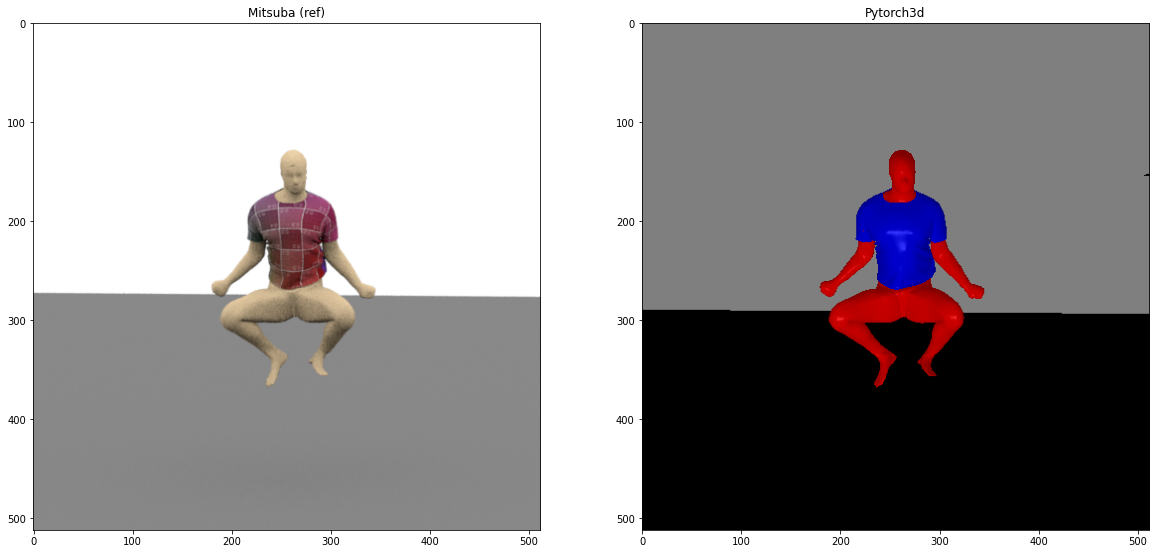

In [81]:
image = renderer(mesh)   # (1, H, W, 4)
ref_image = cv2.imread('data/radek/out.png')
ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(ref_image)

ax.set_title("Mitsuba (ref)")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(image.squeeze().cpu().numpy())
ax.set_title("Pytorch3d")

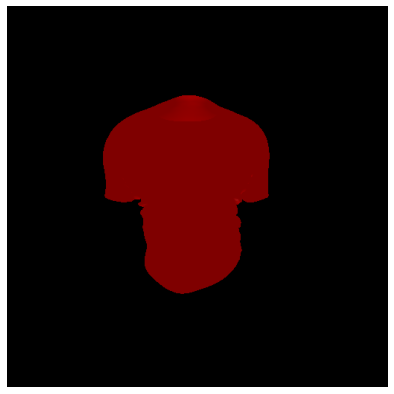

In [60]:
device = torch.device("cuda:0")

obj_filename = os.path.join(DATA_ROOT, 'meshes/SPRING_MALE_RESAMPLED/mesh88_animated/14/14_14/simulated/tshirt_final_fine/00430_00.obj')
mesh = load_objs_as_meshes([obj_filename], device=device)

verts1, faces1 = mesh.get_mesh_verts_faces(0)

tex1 = torch.ones_like(verts1).cuda()
tex1[:, 1:] *= 0.0  # red
tex = torch.cat([tex1])[None]  # (1, 204, 3)
textures = Textures(verts_rgb=tex.cuda())


mesh = Meshes(verts=[verts1], faces=[faces1], textures=textures)
mesh.scale_verts_(0.001)

batch_size = 1
R, T = look_at_view_transform(dist=1, elev=1, azim=0)
R = R.repeat(batch_size, 1, 1)
T = T.repeat(batch_size, 1)
T[0, 1] = -1.5
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T, zfar=10000)

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ), 
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
    )
)

# Render the mesh
image = renderer(mesh)   # (1, H, W, 4)


plt.figure(figsize=(7,7))
plt.imshow(image.squeeze().cpu().numpy())
plt.grid("off");
plt.axis('off');